In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, roc_curve, RocCurveDisplay, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_recall_fscore_support

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Data Loading and Inspection

In [2]:
data = pd.read_csv('bank.csv', delimiter = ';')

In [3]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [4]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


# Data Cleaning and Preparation

In [6]:
data[data.isnull().any(axis = 1)]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y


In [7]:
features = data.drop('y', axis = 1)

In [8]:
cat_df = features.select_dtypes(include = 'object')

In [9]:
cat_df.columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object')

In [398]:
cat_encoder = OneHotEncoder()
X_cat = cat_df.drop('month', axis = 1)
X_cat = pd.DataFrame((cat_encoder.fit_transform(X_cat).toarray()), columns = cat_encoder.get_feature_names())

In [399]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['y'])

In [400]:
scaler = StandardScaler()
num_df = data.select_dtypes(include = np.number)
X_num = pd.DataFrame(scaler.fit_transform(num_df), columns = num_df.columns)

In [401]:
X = pd.concat([X_cat, X_num], axis = 1)

In [402]:
X.head()

,x0_0,x0_1,x0_2,x0_3,x0_4,x0_5,x0_6,x0_7,x0_8,x0_9,...,x7_1,x7_2,x7_3,age,balance,day,duration,campaign,pdays,previous
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-1.056270,0.121072,0.374052,-0.711861,-0.576829,-0.407218,-0.320413
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,-0.772583,1.118644,-0.596026,-0.169194,-0.576829,2.989044,2.041734
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.583458,-0.024144,0.010273,-0.303898,-0.576829,2.899143,0.270124
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-1.056270,0.017726,-1.566105,-0.250017,0.387967,-0.407218,-0.320413
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.686036,-0.472753,-1.323585,-0.146102,-0.576829,-0.407218,-0.320413


In [403]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Applying Classification Models

In [404]:
def con_mat_score(x, y, x_test, y_test, model):          # Function to display acurracy and confusion matrix of results
    model.fit(x, y)
    pred = model.predict(x_test)
    mat = confusion_matrix(y_test, pred)
    print('Score by '+ str(model) + ':' , accuracy_score(y_test, pred))
    print(sns.heatmap(mat, annot = True,fmt='g')) 
    
    pred_prob = model.predict_proba(x_test)[:,1]
    fpr, tpr, thr = roc_curve(y_test, pred_prob)
    display = RocCurveDisplay(fpr = fpr, tpr = tpr).plot()
    
    return display

# Logistic Regression

Score by LogisticRegression(class_weight='balanced', max_iter=10000): 0.8489314664701547
AxesSubplot(0.125,0.125;0.62x0.755)


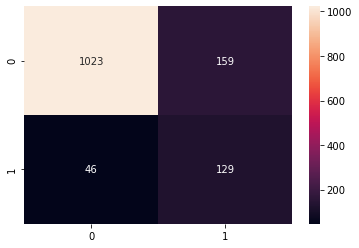

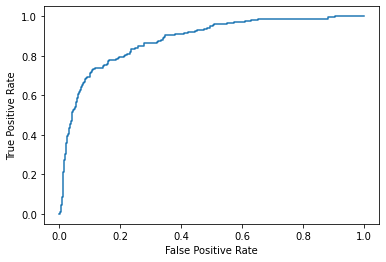

In [405]:
logreg = LogisticRegression(class_weight = 'balanced', max_iter = 10000)
con_mat_score(X_train, y_train, X_test, y_test, logreg)

# KNeighborsClassifier

Score by KNeighborsClassifier(): 0.8791451731761238
AxesSubplot(0.125,0.125;0.62x0.755)


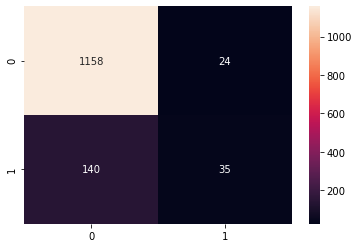

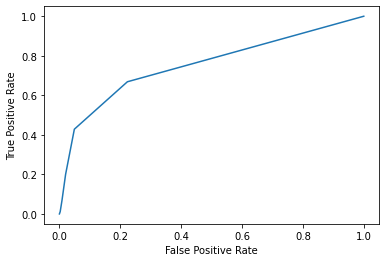

In [406]:
knn = KNeighborsClassifier()
con_mat_score(X_train, y_train, X_test, y_test, knn)

# DecisionTreeClassifier

Score by DecisionTreeClassifier(): 0.8607221812822402
AxesSubplot(0.125,0.125;0.62x0.755)


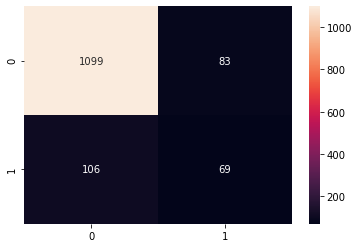

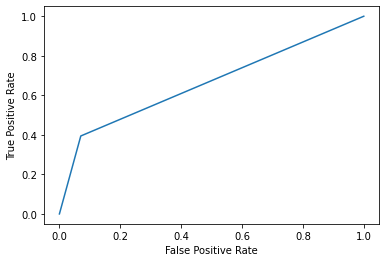

In [407]:
dtc = DecisionTreeClassifier()
con_mat_score(X_train, y_train, X_test, y_test, dtc)

# Linear Discriminant Analysis

Score by LinearDiscriminantAnalysis(): 0.899042004421518
AxesSubplot(0.125,0.125;0.62x0.755)


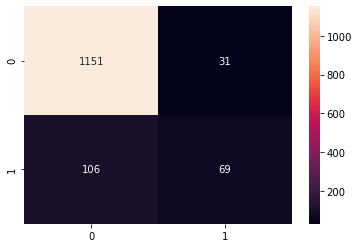

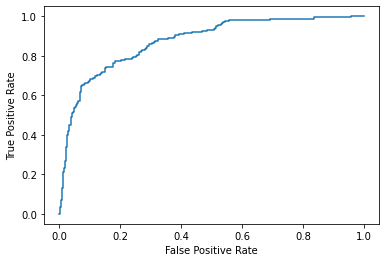

In [408]:
lda = LinearDiscriminantAnalysis()
con_mat_score(X_train, y_train, X_test, y_test, lda)

# ROC Curve Comparison

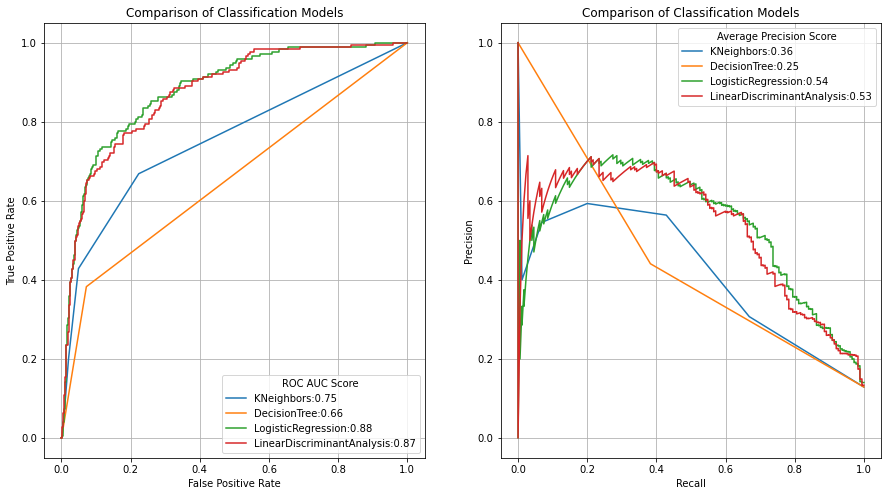

In [409]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize = (15,8))
fprs = []
def compare_roc_curves(model_list, x_train, y_train, x_test, y_test):
    scores = []
    prec_score = []
    for model in model_list:
        model.fit(x_train, y_train)
        pred = model.predict(x_test)
        pred_prob = model.predict_proba(x_test)[:,1]
        fpr, tpr, thr = roc_curve(y_test, pred_prob)
        prc, rcl, thr1 = precision_recall_curve(y_test, pred_prob) 
        scores.append(np.round(roc_auc_score(y_test, pred_prob), 2))
        prec_score.append(np.round(average_precision_score(y_test, pred_prob, average = 'micro'), 2))
        ax1.plot(fpr, tpr)
        ax2.plot(rcl, prc)
        score = {'score' : scores, 'prec_score' : prec_score}
    return score

model_list = [knn, dtc, logreg, lda ]
plotter = compare_roc_curves(model_list, X_train, y_train, X_test, y_test)
scores = plotter['score']
prec_score = plotter['prec_score']

ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Comparison of Classification Models')
ax1.grid()
ax1.legend([f'KNeighbors:{scores[0]}',
            f'DecisionTree:{scores[1]}',
            f'LogisticRegression:{scores[2]}',
            f'LinearDiscriminantAnalysis:{scores[3]}',
            ],  title =  'ROC AUC Score')

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Comparison of Classification Models')
ax2.grid()

ax2.legend([f'KNeighbors:{prec_score[0]}',
            f'DecisionTree:{prec_score[1]}',
            f'LogisticRegression:{prec_score[2]}',
            f'LinearDiscriminantAnalysis:{prec_score[3]}',
            ], title =  'Average Precision Score')

# Support Vector

Score by SVC(): 0.8865143699336773
AxesSubplot(0.125,0.125;0.62x0.755)


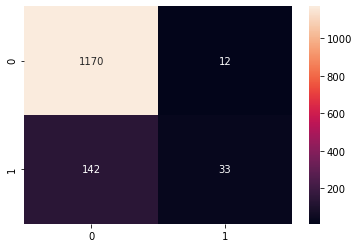

In [410]:
svc = SVC()
svc.fit(X_train, y_train)
pred = svc.predict(X_test)
mat = confusion_matrix(y_test, pred)
print('Score by '+ str(svc) + ':' , accuracy_score(y_test, pred))
print(sns.heatmap(mat, annot = True,fmt='g')) 

# Hyperparameter Tuning

In [411]:
models = {'knn':KNeighborsClassifier(),
          'dtc': DecisionTreeClassifier(),
          'logreg': LogisticRegression(max_iter = 10000),
          'lda': LinearDiscriminantAnalysis(),
          'svc': SVC()}

params = {'knn':{'leaf_size' : [2,10,20,30,40], 
                 'n_neighbors' : [2,6,10,14,16,20],
                 'p':[1,2]},
          
         'dtc': {'max_depth' : [2,3,4,6,10],
                 'max_leaf_nodes' : np.arange(2,5),
                 'criterion' : ['gini','entropy']},

         'logreg': {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
                    'C':[100, 10, 1.0, 0.1, 0.01]},
          
         'lda': {},
          
         'svc': {'kernel' : ['poly', 'rbf', 'sigmoid'],
                 'C' : [50, 10, 1.0, 0.1, 0.01]} 
         }

In [412]:
model_list = []
for key in models.keys():
    model = models[key]
    param = params[key]
    grid = GridSearchCV(model, param, cv = 3)
    grid.fit(X_train, y_train)
    model_list.append(grid.best_estimator_)

In [413]:
model_list

[KNeighborsClassifier(leaf_size=2, n_neighbors=20),
 DecisionTreeClassifier(max_depth=2, max_leaf_nodes=3),
 LogisticRegression(max_iter=10000, solver='newton-cg'),
 LinearDiscriminantAnalysis(),
 SVC()]

In [414]:
report = []
for model in model_list:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report.append(precision_recall_fscore_support(y_test, y_pred, average = 'weighted'))

In [415]:
model_names = ['KNNeighbor','Decision Tree Classifier', 'Logistic Regression', 'Linear Discriminant', 'Support Vector' ]
report_df = pd.DataFrame(report, columns = ['Precision Score', 'Recall Score', 'F Score', 'Support'])

In [416]:
report_df['models'] = model_names
report_df = report_df.set_index('models')
final_report = report_df.drop('Support', axis = 1)

In [417]:
final_report.sort_values(by = 'F Score', ascending = False)

,Precision Score,Recall Score,F Score
models,,,
Linear Discriminant,0.886569,0.899042,0.886827
Logistic Regression,0.881679,0.895357,0.876552
Support Vector,0.871336,0.886514,0.855942
Decision Tree Classifier,0.866369,0.884304,0.852738
KNNeighbor,0.843786,0.874724,0.831482


In [418]:
dtc = DecisionTreeClassifier(max_depth=2, max_leaf_nodes =4 )

In [419]:
dtc.fit(X_train, y_train)
dtc.score(X_test, y_test)

0.8968312453942521

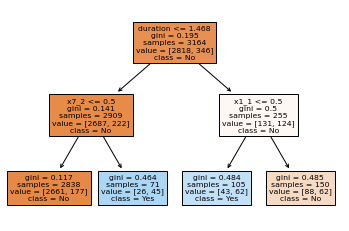

In [420]:
plot_tree(dtc, class_names = ['No', 'Yes'], feature_names = X_train.columns, filled = True)
plt.savefig('tree.pdf')